[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/moon_oed/blob/main/00_d_0_learnpost_fixed_mdn.ipynb)

In [1]:
# MAKE SURE TO RUN THIS CELL FIRST
# this might take a minute or two
# This cell will install the necessary dependencies and import the necessary modules for the notebook to run in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! rm -rf *
        ! git clone --quiet https://github.com/dominik-strutz/moon_oed tmp
        ! mv tmp/* .
        ! rm -rf tmp
        # only install the first 8 lines of the requirements file to only install the necessary dependencies
        ! head -4 requirements.txt > tmp.txt
        ! mv tmp.txt requirements.txt 
        ! pip install -q -r requirements.txt
        dependencies_installed = True
    from google.colab import output
    output.enable_custom_widget_manager()

If you are working in Google Colab you can change the instance from 'CPU' to a GPU of your choice. This will speed up the training process.

In [2]:
import os

import torch

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from zuko.distributions import Joint, Truncated, Uniform, Normal, Independent

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

In [ ]:
import pandas as pd

kernel_df = pd.read_csv('data/sensitivity_kernels/sensitivity_kernels.csv')
freqs = kernel_df.keys()

velocity_model = pd.read_csv('data/velocity_model_no_ice.csv')
depths = torch.tensor(velocity_model['depth'].values)
vp_model = torch.tensor(velocity_model['vp'].values)
vs_model = torch.tensor(velocity_model['vs'].values)

velocity_model_ice = pd.read_csv('data/velocity_model_ice.csv')
vp_model_ice = torch.tensor(velocity_model_ice['vp'].values)
vs_model_ice = torch.tensor(velocity_model_ice['vs'].values)

vp_homogeneous = vp_model[:5].mean().item()
vp_ice_homogeneous = vp_model_ice[:5].mean().item()

print('vp_homogeneous:', vp_homogeneous)
print('vp_ice_homogeneous:', vp_ice_homogeneous)

vp_homogeneous: 108.0
vp_ice_homogeneous: 332.0


## Construct Design

In [4]:
length_x = 500
length_y = 500 

N_rec = 10

# generate 10 random receiver positions
# draw from sobol sequence to have near equidistant points
# which should be good as a first guess of a good receiver layout
from torch.quasirandom import SobolEngine
sobol = SobolEngine(dimension=2, scramble=True, seed=19)

design = sobol.draw(N_rec)
design[:, 0] *= length_x
design[:, 1] *= length_y

## Construct True Model

In [5]:
true_model_mean = torch.tensor(
    [[300, 230]])
true_model_std = torch.tensor(
    [[40, 60]])
true_model_amp = torch.tensor(
    [vp_ice_homogeneous+10])
true_model_theta = torch.tensor(
    [0.3*torch.pi])

true_model = torch.hstack([
    true_model_mean, true_model_std,
    true_model_amp.unsqueeze(-1),
    true_model_theta.unsqueeze(-1)]).squeeze(0)

## Forward Model and Data Likelihood

In [6]:
from helpers.forward import ForwardModelHomogeneous, DataLikelihoodHomogeneous

data_noise = 0.2

forward_model = ForwardModelHomogeneous(vp_homogeneous)
data_likelihood = DataLikelihoodHomogeneous(forward_model, data_noise)

## Prior Distribution

In [7]:
coordinate_prior = Independent(
    Truncated(
        Normal(torch.tensor([250.0, 250.0]), torch.tensor([200.0, 200.0])),
        lower=0.0, upper=length_x), 1)
std_prior = Independent(
    Truncated(
        Normal(torch.tensor([50.0, 50.0]), torch.tensor([30.0, 30.0])),
        lower=10.0, upper=100.0), 1)
amp_prior = Independent(Normal(torch.tensor([350.0]), 10.0),1)
theta_prior = Independent(Uniform(torch.tensor([0.0]), torch.tensor([0.5*torch.pi])), 1)

parameter_names = ['x', 'y', 'std_x', 'std_y', 'amp', 'theta']
prior_dist = Joint(coordinate_prior, std_prior, amp_prior, theta_prior)

# Generate Synthetic Data

In [8]:
N_init = 1000

torch.manual_seed(0)

init_models = prior_dist.sample((N_init,))

init_data = forward_model(init_models, design)
mean_design = design.mean(dim=0, keepdim=True)
std_design = design.std(dim=0, keepdim=True)

# Normalize edge features (train data)
mean_init_data = init_data.mean(dim=0, keepdim=True)
std_init_data = init_data.std(dim=0, keepdim=True)

mean_init_models = init_models.mean(dim=0, keepdim=True)
std_init_models = init_models.std(dim=0, keepdim=True)

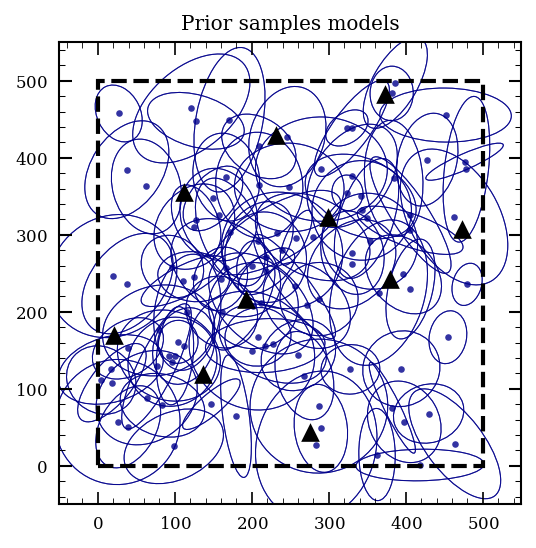

In [9]:
from helpers.plotting import plot_ellipses
# Plot the setup
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

plot_ellipses(ax, init_models[:100, :2], init_models[:100, 2:4],
              init_models[:100, 5], init_models[:100, 4],
              scatter_kwargs=dict(c='darkblue', s=10, alpha=0.8),
              ellipse_kwargs=dict(edgecolor='darkblue', linewidth=0.5, alpha=0.8)
)

ax.scatter(design[:, 0], design[:, 1],
           linewidths=0,
           marker='^', color='k', s=80)

ax.set_title('Prior samples models')

buffer=50

ax.set_xlim(0-buffer, length_x+buffer)
ax.set_ylim(0-buffer, length_y+buffer)
# draw rectangle
ax.add_patch(plt.Rectangle(
    (0, 0), length_x, length_y,
    fill=None, linestyle='dashed', color='black', linewidth=2))

ax.set_aspect('equal')

plt.show()

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


Number of parameters in ConditionalADVI: 151564


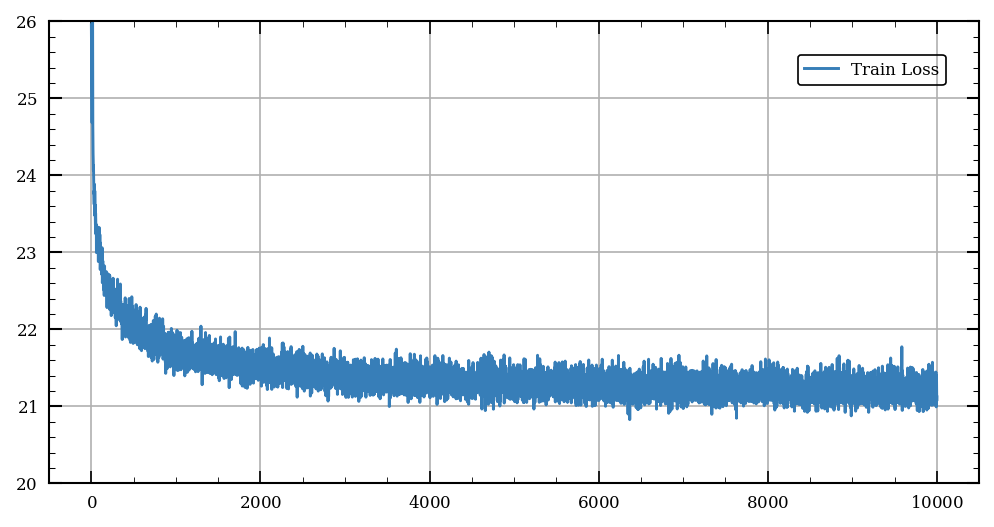

In [11]:
from helpers.variational import ConditionalGaussian

conditional_gaussian = ConditionalGaussian(
    N_rec=N_rec,
    features=len(parameter_names),
    model_mean=mean_init_models,
    model_std=std_init_models,
    data_mean=mean_init_data,
    data_std=std_init_data,
    design_mean=mean_design,
    design_std=std_design,
    hidden_features=(256, 256, 256),
).to(device)

# Print the number of parameters
num_params = sum(p.numel() for p in conditional_gaussian.parameters() if p.requires_grad)
print(f'Number of parameters in ConditionalADVI: {num_params}')

N_steps = 10000
N_batch = 1024


# filename = 'data/models/00_d_0_fixed_mdn.pth'
filename = None
optimizer_kwargs = {
    'flow': {'lr': 1e-3},
}

flow_optimizer = torch.optim.Adam(
    conditional_gaussian.parameters(), **optimizer_kwargs['flow'])

design = design.to(device)

if filename is not None and os.path.exists(filename):
    checkpoint = torch.load(filename)
    conditional_gaussian.load_state_dict(checkpoint['model_state_dict'])
    flow_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss_list = checkpoint['loss_list']
else:
    loss_list = []

    for step in (pbar := tqdm(range(N_steps), desc='Epochs')):
        
        flow_optimizer.zero_grad()
        
        model_i = prior_dist.sample((N_batch,)).to(device)
        data_i = data_likelihood(model_i, design).rsample()

        posterior = conditional_gaussian(data_i, design.unsqueeze(0).repeat(N_batch, 1, 1))
        loss = -posterior.log_prob(model_i).mean()

        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            conditional_gaussian.parameters(), 1.0)

        flow_optimizer.step()

        loss_list.append(loss.item())
        pbar.set_postfix(loss_list=torch.tensor(loss_list[-100:]).mean().item())

    loss_list = torch.tensor(loss_list)

    # Save the model and optimizer state
    if filename is not None:
        torch.save({
            'model_state_dict': conditional_gaussian.state_dict(),
            'optimizer_state_dict': flow_optimizer.state_dict(),
            'loss_list': loss_list,
        }, filename)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(torch.linspace(0, N_steps, len(loss_list)), loss_list, label='Train Loss')

ax.set_ylim(20, 26)
ax.grid(True)

ax.legend()
plt.show()


In [12]:
conditional_gaussian.eval();
conditional_gaussian.to('cpu');

design = design.to('cpu');


In [13]:
# Generate observed data
test_index = 3

observed_data = forward_model(true_model.unsqueeze(0), design).squeeze(0)

# Generate posterior samples using the ConditionalADVI model
N_posterior_samples = 10000
posterior_samples = conditional_gaussian(
    observed_data.unsqueeze(0), design.unsqueeze(0)).sample((N_posterior_samples,)).squeeze(1)

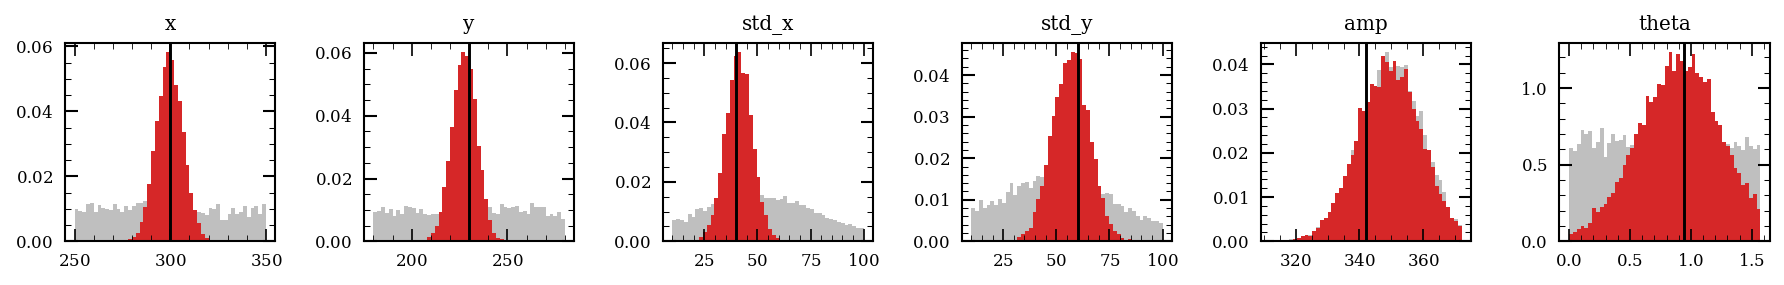

In [14]:
prior_samples = prior_dist.sample((int(1e4),))

param_limits = [
    [ true_model[0].item()-50,  true_model[0].item()+50],
    [ true_model[1].item()-50,  true_model[1].item()+50],
    [10, 100],
    [10, 100],
    [true_model[4].item()-30,  true_model[4].item()+30],
    [0, 0.5*torch.pi]
]
from helpers.plotting import (
    plot_marginal_histogramms,
    plot_single_posterior,
    plot_n_posterior,
)

plot_marginal_histogramms(prior_samples, posterior_samples, param_limits, true_model, parameter_names)

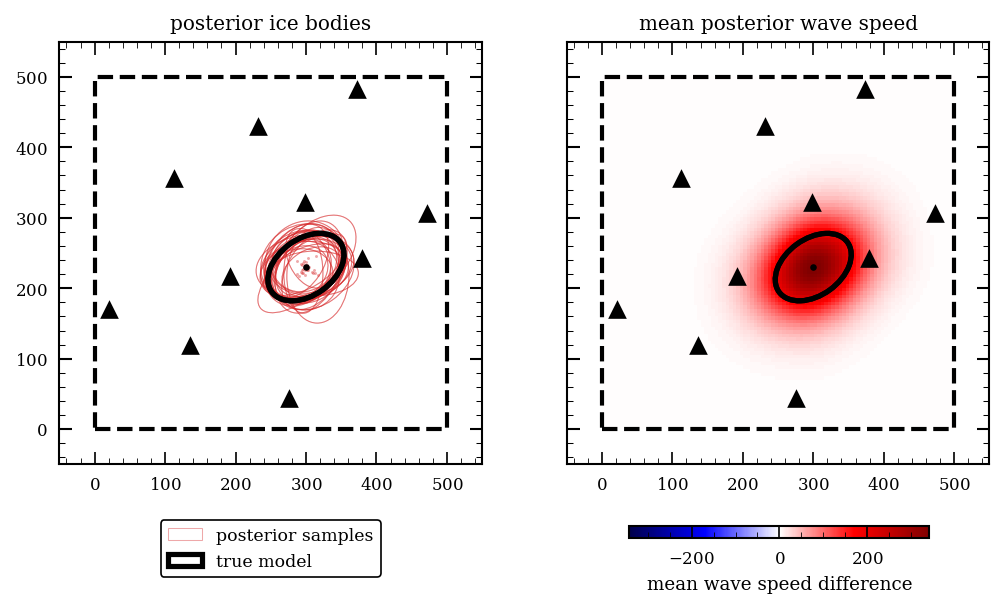

In [15]:
plot_single_posterior(posterior_samples, true_model, design, length_x, length_y)

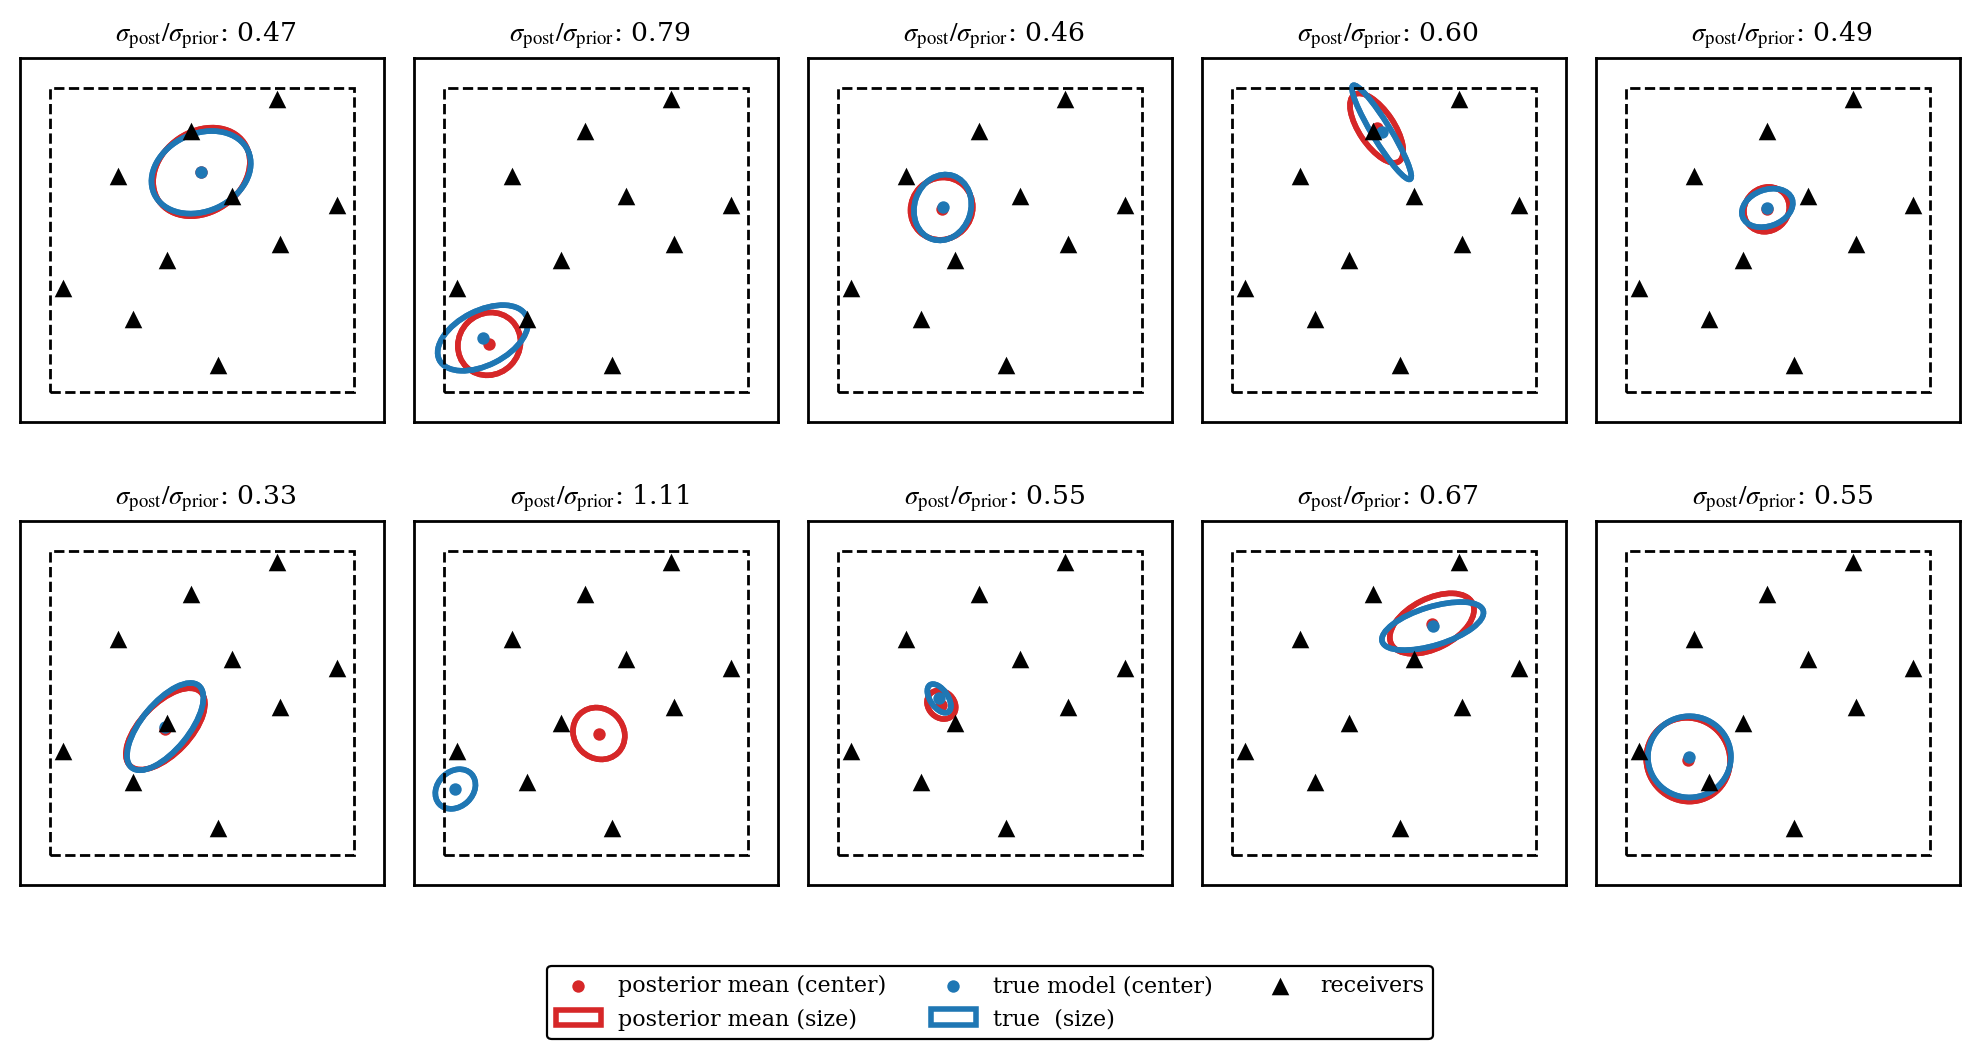

In [16]:
# Call the plotting function
plot_n_posterior(
    prior_dist,
    forward_model,
    conditional_gaussian,
    design,
    length_x, length_y)

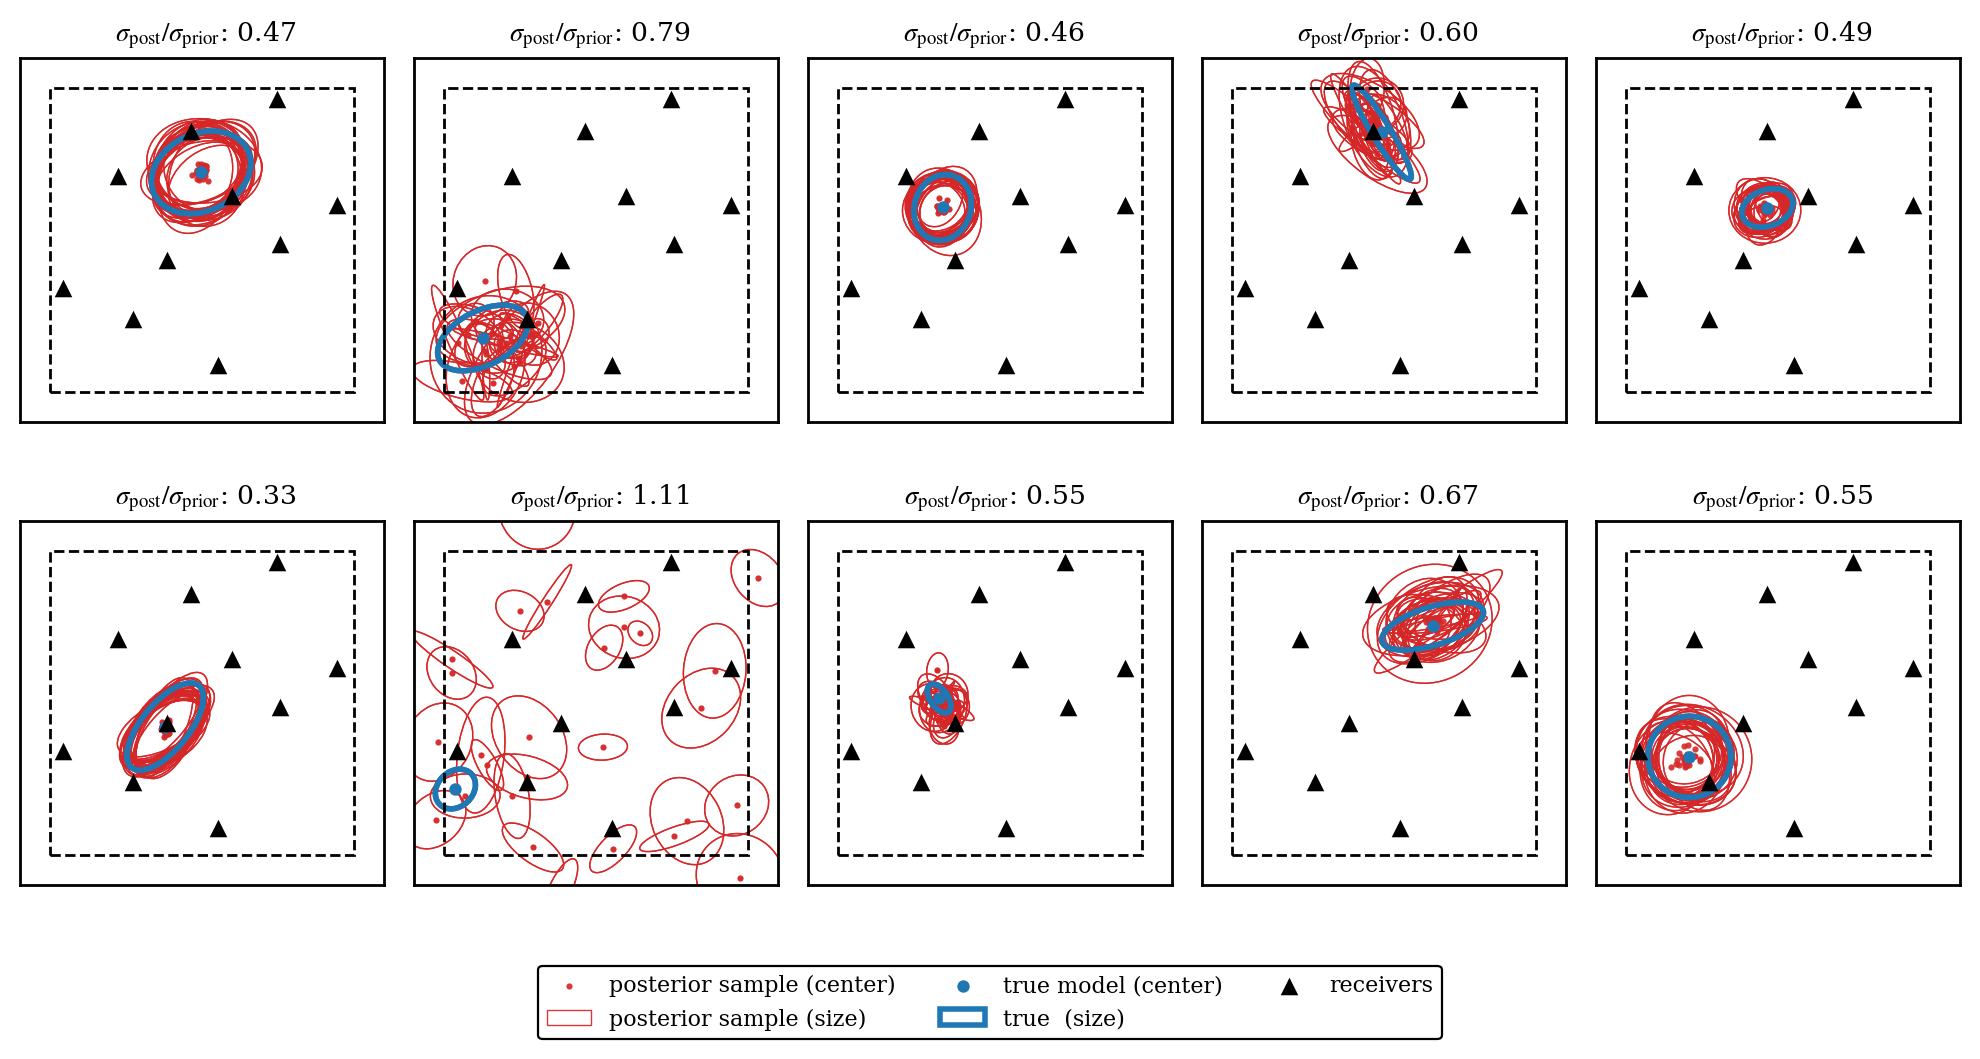

In [17]:
# Call the plotting function
plot_n_posterior(
    prior_dist,
    forward_model,
    conditional_gaussian,
    design,
    length_x, length_y,
    plot_mean=False,
    plot_samples=True)